# Train Interspeech

## Data

In [1]:
import pandas as pd

In [2]:
balanced = False

In [3]:
preprocessed = False

In [4]:
# Cargar los CSV
df1 = pd.read_csv("data/balanced_pseudo_female_todas_emociones_reducido.csv")  # Primer CSV
df2 = pd.read_csv("data/transcripts.csv")  # Segundo CSV ahora es transcript.csv

# Eliminar ".txt" de la columna "FileName" en df2
df2["FileName"] = df2["FileName"].str.replace(".txt", "", regex=False)

# Unir los DataFrames por la columna "FileName", seleccionando solo "FileName" y "text" del segundo CSV
data = df1.merge(df2[['FileName', 'text']], on="FileName", how="left")

# Mostrar la cantidad de filas antes de eliminar nulos
print(f"Filas antes de eliminar nulos: {len(data)}")

# Eliminar filas con valores nulos en la columna 'text'
data = data.dropna(subset=['text'])

# Mostrar la cantidad de filas después de eliminar nulos
print(f"Filas después de eliminar nulos: {len(data)}")

Filas antes de eliminar nulos: 27076
Filas después de eliminar nulos: 27076


In [5]:
if balanced:
    # Paso 1: Determinar el tamaño mínimo entre las clases
    min_count = data['PseudoEmo'].value_counts().min()

    # Paso 2: Submuestrear cada clase
    data = data.groupby('PseudoEmo').apply(lambda x: x.sample(min_count)).reset_index(drop=True)

    # Paso 3: Verificar el balance
    print(data['PseudoEmo'].value_counts())
    print(len(data))

    data.to_csv('data/balanced_pseudo_female.csv', index=False)


In [6]:
# Filtrar los datos en tres conjuntos basados en la columna 'Split_Set'
train_df = data.loc[data['NewPartition'] == 'Train']
dev_df = data.loc[data['NewPartition'] == 'Evaluation']
test_df = data.loc[data['NewPartition'] == 'Test']

# Verifica las primeras filas de cada conjunto
print("Conjunto Train:")
print(train_df.head())

print("Conjunto Development:")
print(dev_df.head())

print("Conjunto Test:")
print(test_df.head())

Conjunto Train:
                FileName          worker  primary_emotion EmoClass  EmoNum  \
0  MSP-PODCAST_0002_0061  WORKER00003259             Fear        F       7   
1  MSP-PODCAST_0002_0061  WORKER00001171         Contempt        C       4   
2  MSP-PODCAST_0002_0061  WORKER00003260             Fear        F       7   
3  MSP-PODCAST_0002_0061  WORKER00003261         Surprise        U       5   
4  MSP-PODCAST_0002_0061  WORKER00003262  Other-Concerned        O       8   

   WorkerNum NewPartition                                               text  
0       3259        Train  yeah. so, but molly, i mean, this was really o...  
1       1171        Train  yeah. so, but molly, i mean, this was really o...  
2       3260        Train  yeah. so, but molly, i mean, this was really o...  
3       3261        Train  yeah. so, but molly, i mean, this was really o...  
4       3262        Train  yeah. so, but molly, i mean, this was really o...  
Conjunto Development:
                 Fi

In [7]:
# # Establecer la semilla para garantizar reproducibilidad
# seed = 42

# # Seleccionar aleatoriamente las primeras N filas del conjunto de entrenamiento
# train_df = train_df.sample(n=1000, random_state=seed)

# # Seleccionar aleatoriamente las primeras N filas del conjunto de desarrollo
# dev_df = dev_df.sample(n=250, random_state=seed)

In [8]:
id2label = {
        0: 'N',  # Neutral
        1: 'H',  # Happy
        2: 'A',  # Angry
        3: 'S',  # Sad
        4: 'C',  # Contempt
        5: 'U',  # Surprise
        6: 'D',  # Disgust
        7: 'F',  # Fear
        8: 'O'   # Other
    }
label2id = {
        'N': 0,  # Neutral
        'H': 1,  # Happy
        'A': 2,  # Angry
        'S': 3 , # Sad
        'C': 4,  # Contempt
        'U': 5,  # Surprise
        'D': 6,  # Disgust
        'F': 7,  # Fear
        'O': 8   # Other
    }

num_labels = len(id2label.keys())
col_emo = "EmoNum" # "PseudoEmoNum"

print(f"{id2label=}")
print(f"{label2id=}")
print(f"{num_labels=}")

id2label={0: 'N', 1: 'H', 2: 'A', 3: 'S', 4: 'C', 5: 'U', 6: 'D', 7: 'F', 8: 'O'}
label2id={'N': 0, 'H': 1, 'A': 2, 'S': 3, 'C': 4, 'U': 5, 'D': 6, 'F': 7, 'O': 8}
num_labels=9


In [9]:
# Convertir EmoClass a valores numéricos si es necesario
train_df[col_emo] = train_df[col_emo].astype(int)
dev_df[col_emo] = dev_df[col_emo].astype(int)
test_df[col_emo] = test_df[col_emo].astype(int)

/var/folders/dh/_ks73kfn57l67vxm7b5y16qw0000gn/T/ipykernel_23119/2809703481.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[col_emo] = train_df[col_emo].astype(int)
/var/folders/dh/_ks73kfn57l67vxm7b5y16qw0000gn/T/ipykernel_23119/2809703481.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dev_df[col_emo] = dev_df[col_emo].astype(int)


In [10]:
from datasets import Dataset
from transformers import AutoTokenizer


if preprocessed == False:
    # Modelo
    model_ckpt = "distilbert-base-uncased"
    # model_ckpt = "distilroberta-base"

    # Cargar el tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

    # Función para tokenizar los datos
    def tokenize_function(examples):
        # Verificar que estamos pasando una lista de textos
        texts = examples['text']
        return tokenizer(texts, padding="max_length", truncation=True)

    # Asegurarse de que 'train_df' y 'dev_df' son objetos Dataset de Hugging Face
    train_dataset = Dataset.from_pandas(train_df)
    dev_dataset = Dataset.from_pandas(dev_df)
    test_dataset = Dataset.from_pandas(test_df)
    data_dataset = Dataset.from_pandas(data)


    # Tokenizamos ambos conjuntos de datos
    train_dataset = train_dataset.map(tokenize_function, batched=True)
    dev_dataset = dev_dataset.map(tokenize_function, batched=True)
    test_dataset = test_dataset.map(tokenize_function, batched=True)
    data_dataset = data_dataset.map(tokenize_function, batched=True)


    # Renombrar columna de labels
    train_dataset = train_dataset.rename_column(col_emo, "labels")
    dev_dataset = dev_dataset.rename_column(col_emo, "labels")
    test_dataset = test_dataset.rename_column(col_emo, "labels")
    data_dataset = data_dataset.rename_column(col_emo, "labels")


/Users/jorgegarcelan/Desktop/UNI/6-LAB TSC/interspeech-nlp/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jorgegarcelan/Desktop/UNI/6-LAB TSC/interspeech-nlp/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Map: 100%|██████████| 27076/27076 [00:01<00:00, 16080.86 examples/s]


In [11]:
import re
from datasets import Dataset
from transformers import AutoTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

if preprocessed:
    # Descargar recursos necesarios de NLTK
    nltk.download('stopwords')
    nltk.download('wordnet')

    # Modelo
    model_ckpt = "distilbert-base-uncased"
    tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

    # Stopwords en inglés (puedes cambiar el idioma si es necesario)
    stop_words = set(stopwords.words('english'))

    # Inicializar el lematizador
    lemmatizer = WordNetLemmatizer()

    # Función para limpiar y tokenizar
    def preprocess_and_tokenize(examples):
        processed_texts = []
        for text in examples['text']:
            # Convertir a minúsculas
            text = text.lower()
            # # Eliminar URLs
            # text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
            # # Eliminar menciones y hashtags
            # text = re.sub(r"@\w+|#\w+", "", text)
            # # Eliminar caracteres especiales y puntuación
            # text = re.sub(r"[^a-zA-Z\s]", "", text)
            # # Eliminar números
            # text = re.sub(r"\d+", "", text)
            # # Eliminar palabras de parada
            # words = text.split()
            # words = [word for word in words if word not in stop_words]
            # # Aplicar lematización
            # words = [lemmatizer.lemmatize(word) for word in words]
            # # Unir palabras limpias
            # text = " ".join(words)
            # Añadir texto procesado a la lista
            processed_texts.append(text)
        
        # Tokenizar el texto limpio
        return tokenizer(processed_texts, padding="max_length", truncation=True)

    # Verificar que no haya valores nulos
    train_df = train_df.dropna(subset=["text", "PseudoEmoNum"])
    dev_df = dev_df.dropna(subset=["text", "PseudoEmoNum"])
    test_df = test_df.dropna(subset=["text", "PseudoEmoNum"])

    # Convertir DataFrame a Dataset
    train_dataset = Dataset.from_pandas(train_df)
    dev_dataset = Dataset.from_pandas(dev_df)
    test_dataset = Dataset.from_pandas(test_df)

    # Tokenizar los conjuntos de datos
    train_dataset = train_dataset.map(preprocess_and_tokenize, batched=True, num_proc=4)
    dev_dataset = dev_dataset.map(preprocess_and_tokenize, batched=True, num_proc=4)
    test_dataset = test_dataset.map(preprocess_and_tokenize, batched=True, num_proc=4)

    # Renombrar columna de labels
    train_dataset = train_dataset.rename_column("PseudoEmoNum", "labels")
    dev_dataset = dev_dataset.rename_column("PseudoEmoNum", "labels")
    test_dataset = test_dataset.rename_column("PseudoEmoNum", "labels")

    # Inspeccionar un ejemplo procesado
    print(train_dataset[0])


## Code

In [12]:
from transformers import AutoTokenizer
import torch
print(torch.__version__)  # Esto debería mostrarte la versión de PyTorch instalada

2.5.1


In [13]:
from transformers import AutoModelForSequenceClassification
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels, label2id=label2id, id2label=id2label).to(device)
print(model.num_labels)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


9


In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    # Obtener reporte completo
    report = classification_report(labels, predictions, output_dict=True)
    
    # Obtener la matriz de confusión
    conf_matrix = confusion_matrix(labels, predictions)
    
    # Extraer métricas para cada clase y globales
    metrics = {
        'accuracy': report['accuracy'],
        'macro_f1': report['macro avg']['f1-score'],
        'weighted_f1': report['weighted avg']['f1-score'],
        # 'weighted_precision': report['weighted avg']['precision'],
        # 'weighted_recall': report['weighted avg']['recall'],
        'confusion_matrix': conf_matrix.tolist()  # Convertir a lista para asegurarse de que es serializable si es necesario
    }
    
    # # Añadir métricas específicas por clase si se requiere
    # for label, scores in report.items():
    #     if label not in ["accuracy", "macro avg", "weighted avg"]:
    #         metrics[f'{label}_precision'] = scores['precision']
    #         metrics[f'{label}_recall'] = scores['recall']
    #         metrics[f'{label}_f1'] = scores['f1-score']
    #         metrics[f'{label}_support'] = scores['support']
    
    return metrics

In [15]:
from transformers import Trainer, TrainingArguments

batch_size = 32
logging_steps = len(train_dataset) // batch_size
model_name = f"{model_ckpt}-finetuned-female"
training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=10,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps,
    # push_to_hub=True,
    log_level="error"
)

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    tokenizer=tokenizer
)

/Users/jorgegarcelan/Desktop/UNI/6-LAB TSC/interspeech-nlp/.venv/lib/python3.9/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/var/folders/dh/_ks73kfn57l67vxm7b5y16qw0000gn/T/ipykernel_23119/3782960661.py:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [16]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Weighted F1,Confusion Matrix
1,2.014500,2.004389,0.280901,0.171912,0.240249,"[[551, 152, 144, 93, 12, 27, 26, 0, 0], [277, 245, 126, 55, 4, 21, 24, 0, 0], [172, 59, 262, 67, 20, 28, 39, 0, 0], [223, 50, 74, 112, 10, 19, 15, 0, 0], [178, 53, 167, 28, 15, 9, 26, 0, 0], [142, 69, 44, 29, 6, 18, 15, 0, 0], [74, 28, 84, 26, 6, 8, 31, 0, 0], [106, 30, 34, 30, 12, 5, 7, 0, 0], [86, 31, 41, 22, 2, 12, 12, 0, 0]]"
2,1.825600,2.041368,0.256317,0.173612,0.231450,"[[465, 131, 113, 162, 34, 54, 32, 14, 0], [262, 196, 130, 63, 19, 41, 30, 11, 0], [150, 59, 206, 90, 38, 28, 61, 15, 0], [194, 43, 59, 160, 15, 12, 15, 5, 0], [140, 47, 129, 62, 28, 17, 45, 8, 0], [111, 58, 47, 33, 26, 23, 15, 10, 0], [67, 30, 59, 29, 14, 9, 46, 3, 0], [77, 29, 28, 51, 13, 12, 12, 2, 0], [65, 32, 37, 40, 8, 11, 10, 3, 0]]"
3,1.681200,2.116823,0.238106,0.182194,0.232216,"[[395, 81, 116, 127, 101, 99, 46, 40, 0], [212, 151, 111, 64, 55, 111, 34, 14, 0], [96, 42, 182, 61, 107, 57, 74, 28, 0], [156, 29, 47, 117, 51, 36, 30, 37, 0], [105, 36, 98, 47, 94, 32, 55, 9, 0], [92, 44, 38, 30, 38, 40, 25, 16, 0], [54, 10, 42, 32, 38, 21, 54, 6, 0], [54, 17, 20, 39, 42, 25, 14, 13, 0], [61, 13, 33, 26, 17, 31, 16, 9, 0]]"
4,1.583900,2.151737,0.235374,0.163302,0.212651,"[[530, 60, 35, 136, 82, 66, 65, 31, 0], [309, 122, 56, 62, 60, 72, 65, 6, 0], [187, 43, 80, 77, 114, 29, 93, 24, 0], [230, 22, 18, 119, 47, 19, 17, 31, 0], [162, 27, 53, 48, 98, 21, 64, 3, 0], [136, 41, 13, 23, 45, 19, 33, 13, 0], [88, 13, 16, 23, 46, 12, 55, 4, 0], [83, 15, 5, 39, 29, 19, 23, 11, 0], [87, 16, 12, 30, 21, 17, 17, 6, 0]]"
5,1.513800,2.159032,0.246756,0.175936,0.227982,"[[460, 87, 89, 188, 60, 60, 38, 23, 0], [269, 148, 116, 87, 46, 63, 19, 4, 0], [145, 61, 170, 108, 74, 21, 52, 16, 0], [189, 35, 36, 163, 32, 23, 10, 15, 0], [132, 42, 96, 76, 74, 13, 40, 3, 0], [120, 49, 36, 39, 29, 15, 23, 12, 0], [76, 18, 41, 33, 30, 12, 44, 3, 0], [72, 29, 12, 49, 26, 9, 17, 10, 0], [72, 22, 25, 47, 13, 13, 9, 5, 0]]"
6,1.460600,2.155265,0.249033,0.180519,0.233588,"[[434, 167, 79, 115, 91, 53, 37, 29, 0], [232, 236, 85, 59, 50, 60, 25, 5, 0], [140, 90, 132, 72, 107, 26, 63, 17, 0], [177, 56, 34, 130, 44, 17, 10, 35, 0], [138, 58, 79, 45, 91, 16, 46, 3, 0], [111, 81, 27, 24, 29, 12, 26, 13, 0], [77, 29, 33, 22, 40, 9, 43, 4, 0], [70, 38, 11, 30, 29, 14, 16, 16, 0], [66, 39, 24, 29, 16, 15, 11, 6, 0]]"
7,1.420500,2.209028,0.224903,0.167616,0.212074,"[[425, 88, 54, 134, 127, 60, 63, 47, 7], [270, 134, 63, 69, 73, 71, 51, 15, 6], [136, 65, 98, 69, 128, 22, 104, 25, 0], [177, 32, 26, 134, 55, 21, 20, 38, 0], [138, 32, 62, 51, 109, 15, 62, 7, 0], [110, 52, 16, 26, 52, 11, 34, 20, 2], [69, 19, 19, 26, 51, 11, 58, 4, 0], [72, 26, 5, 34, 35, 11, 24, 17, 0], [71, 23, 15, 35, 19, 15, 20, 6, 2]]"
8,1.377300,2.225309,0.233098,0.170410,0.219985,"[[408, 111, 92, 160, 109, 65, 37, 23, 0], [243, 172, 105, 78, 65, 71, 15, 3, 0], [140, 74, 142, 82, 121, 24, 44, 20, 0], [174, 42, 41, 137, 58, 14, 12, 25, 0], [129, 41, 77, 65, 101, 18, 41, 4, 0], [108, 64, 29, 37, 39, 11, 22, 13, 0], [68, 22, 42, 25, 48, 8, 40, 4, 0], [64, 28, 8, 41, 36, 15, 19, 13, 0], [63, 28, 30, 37, 18, 16, 8, 6, 0]]"
9,1.352400,2.241526,0.230594,0.175264,0.224418,"[[371, 136, 90, 120, 93, 92, 50, 43, 10], [214, 187, 109, 64, 50, 88, 28, 12, 0], [114, 88, 156, 66, 92, 43, 61, 22, 5], [147, 46, 32, 130, 52, 49, 14, 30, 3], [118, 49, 89, 45, 86, 28, 51, 4, 6], [89, 65, 36, 26, 30, 24, 31, 20, 2], [61, 28, 37, 21, 43, 16, 44, 4, 3], [52, 34, 11, 33, 34, 21, 23, 15, 1], [56, 32, 29, 32, 15, 23, 13, 6, 0]]"
10,1.327200,2.255916,0.230594,0.175047,0.221809,"[[383, 123, 87, 140, 102, 73, 46, 44, 7], [241, 168, 105, 68, 53, 74, 25, 17, 1], [128, 77, 153, 79, 92, 28, 66, 20, 4], [167, 38, 34, 134, 48, 33, 13, 30, 6], [117, 45, 87, 54, 92, 20, 48, 7, 6], [107, 56, 34, 30, 25, 21, 26, 21, 3], [64, 24, 41, 22, 44, 11, 45, 4, 2], [61, 28, 9, 37, 31, 16, 23, 17, 2], [63, 24, 31, 38, 15, 18, 11, 6, 0]]"


/Users/jorgegarcelan/Desktop/UNI/6-LAB TSC/interspeech-nlp/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jorgegarcelan/Desktop/UNI/6-LAB TSC/interspeech-nlp/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jorgegarcelan/Desktop/UNI/6-LAB TSC/interspeech-nlp/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division`

TrainOutput(global_step=7090, training_loss=1.5554145071839411, metrics={'train_runtime': 39243.9768, 'train_samples_per_second': 5.78, 'train_steps_per_second': 0.181, 'total_flos': 3.005133102867456e+16, 'train_loss': 1.5554145071839411, 'epoch': 10.0})

In [17]:
# preds_output = trainer.predict(test_dataset)
# preds_metrics = preds_output.metrics
# preds_metrics

In [18]:
data_dataset

Dataset({
    features: ['FileName', 'worker', 'primary_emotion', 'EmoClass', 'labels', 'WorkerNum', 'NewPartition', 'text', 'input_ids', 'attention_mask'],
    num_rows: 27076
})

In [19]:
# Realizar la predicción con el trainer
preds_output = trainer.predict(data_dataset)
preds_metrics = preds_output.metrics

# Extraer los logits de la predicción
logits = preds_output.predictions

# Aplicar softmax para obtener probabilidades
probs = np.exp(logits) / np.exp(logits).sum(axis=1, keepdims=True)  # Softmax

# Guardar en archivo .npy
output_path = "predicciones_female.npy"
np.save(output_path, probs)

# Confirmar guardado
output_path

'predicciones_female.npy'

In [20]:
probs_cargadas = np.load("predicciones_female.npy")
print(probs_cargadas.shape)  # Debe ser (num_filas, 9)

(27076, 9)


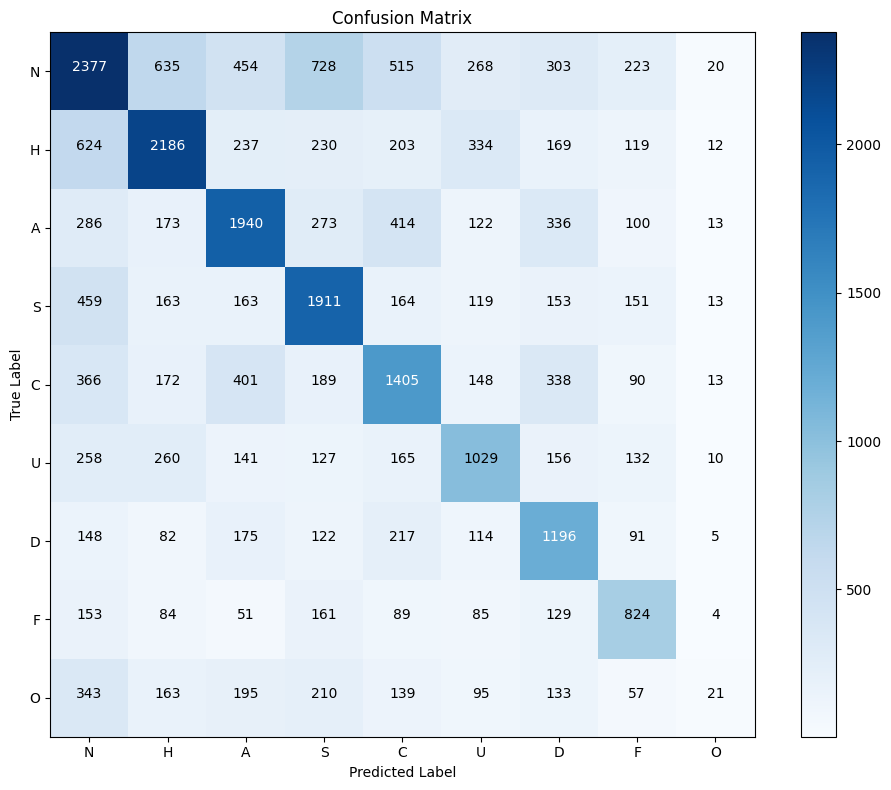

In [21]:
import matplotlib.pyplot as plt
import numpy as np

labels = label2id.keys()
conf_matrix = preds_metrics['test_confusion_matrix']

# Crear el gráfico de la matriz de confusión
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()

# Agregar etiquetas
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)

# Rótulos de valores dentro de cada celda
conf_matrix = np.array(conf_matrix)

# Calcular el umbral
thresh = conf_matrix.max() / 2
for i, j in np.ndindex(conf_matrix.shape):
    plt.text(
        j, i, format(conf_matrix[i, j], 'd'),
        horizontalalignment="center",
        color="white" if conf_matrix[i, j] > thresh else "black"
    )

# Etiquetas de los ejes
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()